### Download C4 dataset and install requirements

In [ ]:
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!mkdir -p content 
%cd content
!wget https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/examples/c4.csv
!wget https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/results/res_c4.csv
%cd ..

### Perform models inference on the [C4 dataset](https://github.com/Chenning-Tao/C4/tree/main/dataset)

In [1]:
import torch
import pandas as pd
from tqdm import tqdm
from unixcoder import UniXcoder
from torch.nn import CosineSimilarity

df = pd.read_csv("content/c4.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cossim = CosineSimilarity(dim=1, eps=1e-8)
model_clone_detection = UniXcoder("Lazyhope/unixcoder-clone-detection")
model_code_search = UniXcoder("Lazyhope/unixcoder-nine-advtest")

model_clone_detection.to(device)
model_code_search.to(device)
tqdm.pandas()

def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)

    return embeddings

def get_pair_similarity(code1, code2, model):
    e1, e2 = get_code_embeddings(code1, model), get_code_embeddings(code2, model)
    score = cossim(e1, e2).cpu().item()
    return score

e:\Miniconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import pandas as pd
from tqdm import tqdm
from unixcoder import UniXcoder
from torch.nn import CosineSimilarity

df = pd.read_csv("content/c4.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cossim = CosineSimilarity(dim=1, eps=1e-8)
model_clone_detection = UniXcoder("Lazyhope/unixcoder-clone-detection")
model_code_search = UniXcoder("Lazyhope/unixcoder-nine-advtest")

model_clone_detection.to(device)
model_code_search.to(device)
tqdm.pandas()

def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)

    return embeddings

def get_pair_similarity(code1, code2, model):
    e1, e2 = get_code_embeddings(code1, model), get_code_embeddings(code2, model)
    score = cossim(e1, e2).cpu().item()
    return score

with torch.no_grad():
    print("Inferencing with UniXCoder - Clone Detection Model")
    clone_detection_scores = df.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_clone_detection), axis=1)
    print("Inferencing with UniXCoder - Code Search Model")
    code_search_scores = df.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_code_search), axis=1)

Inferencing with UniXCoder - Clone Detection Model


100%|██████████| 13704/13704 [21:02<00:00, 10.86it/s]


Inferencing with UniXCoder - Code Search Model


100%|██████████| 13704/13704 [21:34<00:00, 10.59it/s]


In [48]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer

model_codet5 = "Salesforce/codet5-base-multi-sum"
tokenizer = AutoTokenizer.from_pretrained(model_codet5)
model_codet5_sum = AutoModelForSeq2SeqLM.from_pretrained(model_codet5)
text_model = SentenceTransformer("all-mpnet-base-v2", device=device)

def get_code_sum_embedding(func):
    inputs = tokenizer.batch_encode_plus(
        func,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        inputs = {k: v.to(model_codet5_sum.device) for k, v in inputs.items()}
        outputs = model_codet5_sum.generate(**inputs)
    code_snippet_summarization = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return text_model.encode(code_snippet_summarization, convert_to_tensor=True)

In [49]:
def get_pair_sum_similarity(sum1, sum2):
    e3, e4 = get_code_sum_embedding(sum1), get_code_sum_embedding(sum2)
    score = cossim(e3, e4).cpu().item()
    return score

In [51]:
with torch.no_grad():
    print("Inferencing with CodeT5 - Code Summarization Model")
    clone_sum_scores = df.progress_apply(lambda row: get_pair_sum_similarity([row["code1"]], [row["code2"]]), axis=1)

Inferencing with CodeT5 - Code Summarization Model


  9%|▉         | 1299/13704 [45:47<7:17:17,  2.12s/it] 


KeyboardInterrupt: 

## Find the optimal threshold that has maximum f1 score

In [3]:
from sklearn.metrics import recall_score, precision_score, f1_score

def get_optimal_threshold(scores):
    y_true = df["similar"]
    max_tuple = (0, 1) # (f1 score, threshold)
    for threshold in scores:
        y_pred = scores >= threshold
        f1 = f1_score(y_true, y_pred)
        if f1 > max_tuple[0]:
            max_tuple = (f1, threshold)

    optimal_threshold = max_tuple[1]
    return optimal_threshold

In [4]:
print("Finding optimal threshold for UniXCoder - Clone Detection Model")
clone_detection_threshold = get_optimal_threshold(clone_detection_scores)
print(f"Optimal threshold: {clone_detection_threshold}")
print("------------------------------------------")


print("Finding optimal threshold for UniXCoder - Code Search Model")
code_search_threshold = get_optimal_threshold(code_search_scores)
print(f"Optimal threshold: {code_search_threshold}")
print("------------------------------------------")


print("Finding optimal threshold for CodeT5 - Code Summarization Model")
clone_sum_threshold = get_optimal_threshold(clone_sum_scores)
print(f"Optimal threshold: {clone_sum_threshold}")

Finding optimal threshold for UniXCoder - Clone Detection Model
Optimal threshold: 0.43791845440864563

Finding optimal threshold for UniXCoder - Code Search Model
Optimal threshold: 0.6845545768737793


### Highest F1 score

In [6]:
y_true = df["similar"]

y_pred = pd.read_csv("content/res.csv")["predictions"]
print("GraphCodeBERT Model")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"F1: {f1_score(y_true, y_pred)}")
print("------------------------------------------")

clone_detection_pred = clone_detection_scores >= clone_detection_threshold
print("UniXCoder - Clone Detection Model")
print(f"Recall: {recall_score(y_true, clone_detection_pred)}")
print(f"Precision: {precision_score(y_true, clone_detection_pred)}")
print(f"F1: {f1_score(y_true, clone_detection_pred)}")
print("------------------------------------------")

print("UniXCoder - Code Search Model")
code_search_pred = code_search_scores >= code_search_threshold
print(f"Recall: {recall_score(y_true, code_search_pred)}")
print(f"Precision: {precision_score(y_true, code_search_pred)}")
print(f"F1: {f1_score(y_true, code_search_pred)}")
print("------------------------------------------")


print("CodeT5 - Code Summarization Model")
clone_sum_pred = clone_sum_scores >= clone_sum_threshold
print(f"Recall: {recall_score(y_true, clone_sum_pred)}")
print(f"Precision: {precision_score(y_true, clone_sum_pred)}")
print(f"F1: {f1_score(y_true, clone_sum_pred)}")



GraphCodeBERT Model
Recall: 0.9642440163455925
Precision: 0.97563496751329
F1: 0.969906048150323
------------------------------------------
UniXCoder - Clone Detection Model
Recall: 0.9363689433741973
Precision: 0.9633633633633634
F1: 0.9496743635287151
------------------------------------------
UniXCoder - Code Search Model
Recall: 0.8098365440747227
Precision: 0.8596436870642913
F1: 0.8339971443601113
------------------------------------------


## ROC and AUC

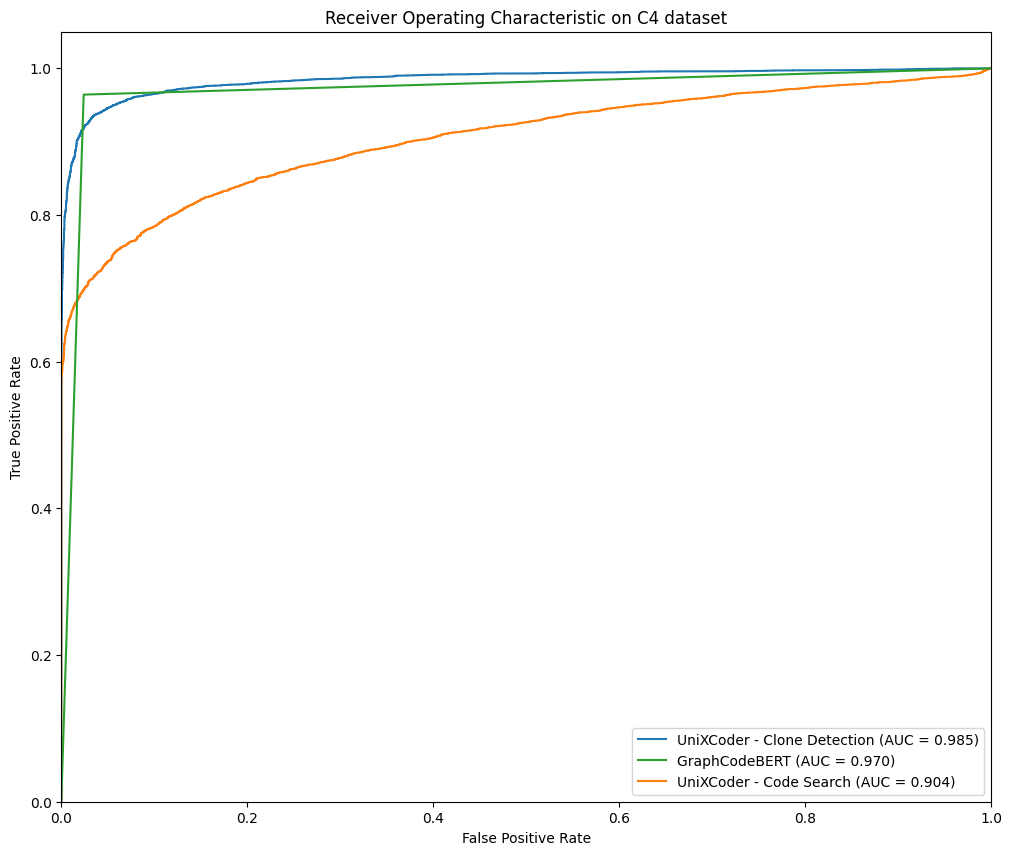

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
fig = plt.figure(figsize=(12, 10))

def roc(y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    model_auc[model_name] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model_name)

roc(clone_detection_scores, "UniXCoder - Clone Detection")
roc(code_search_scores, "UniXCoder - Code Search")
# roc(clone_sum_scores, "CodeT5 - Code Summarization Mixed")
roc(y_pred, "GraphCodeBERT")


# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

# plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic on C4 dataset')
plt.savefig('roc_c4.png')
plt.show()

## Similarity score distribution

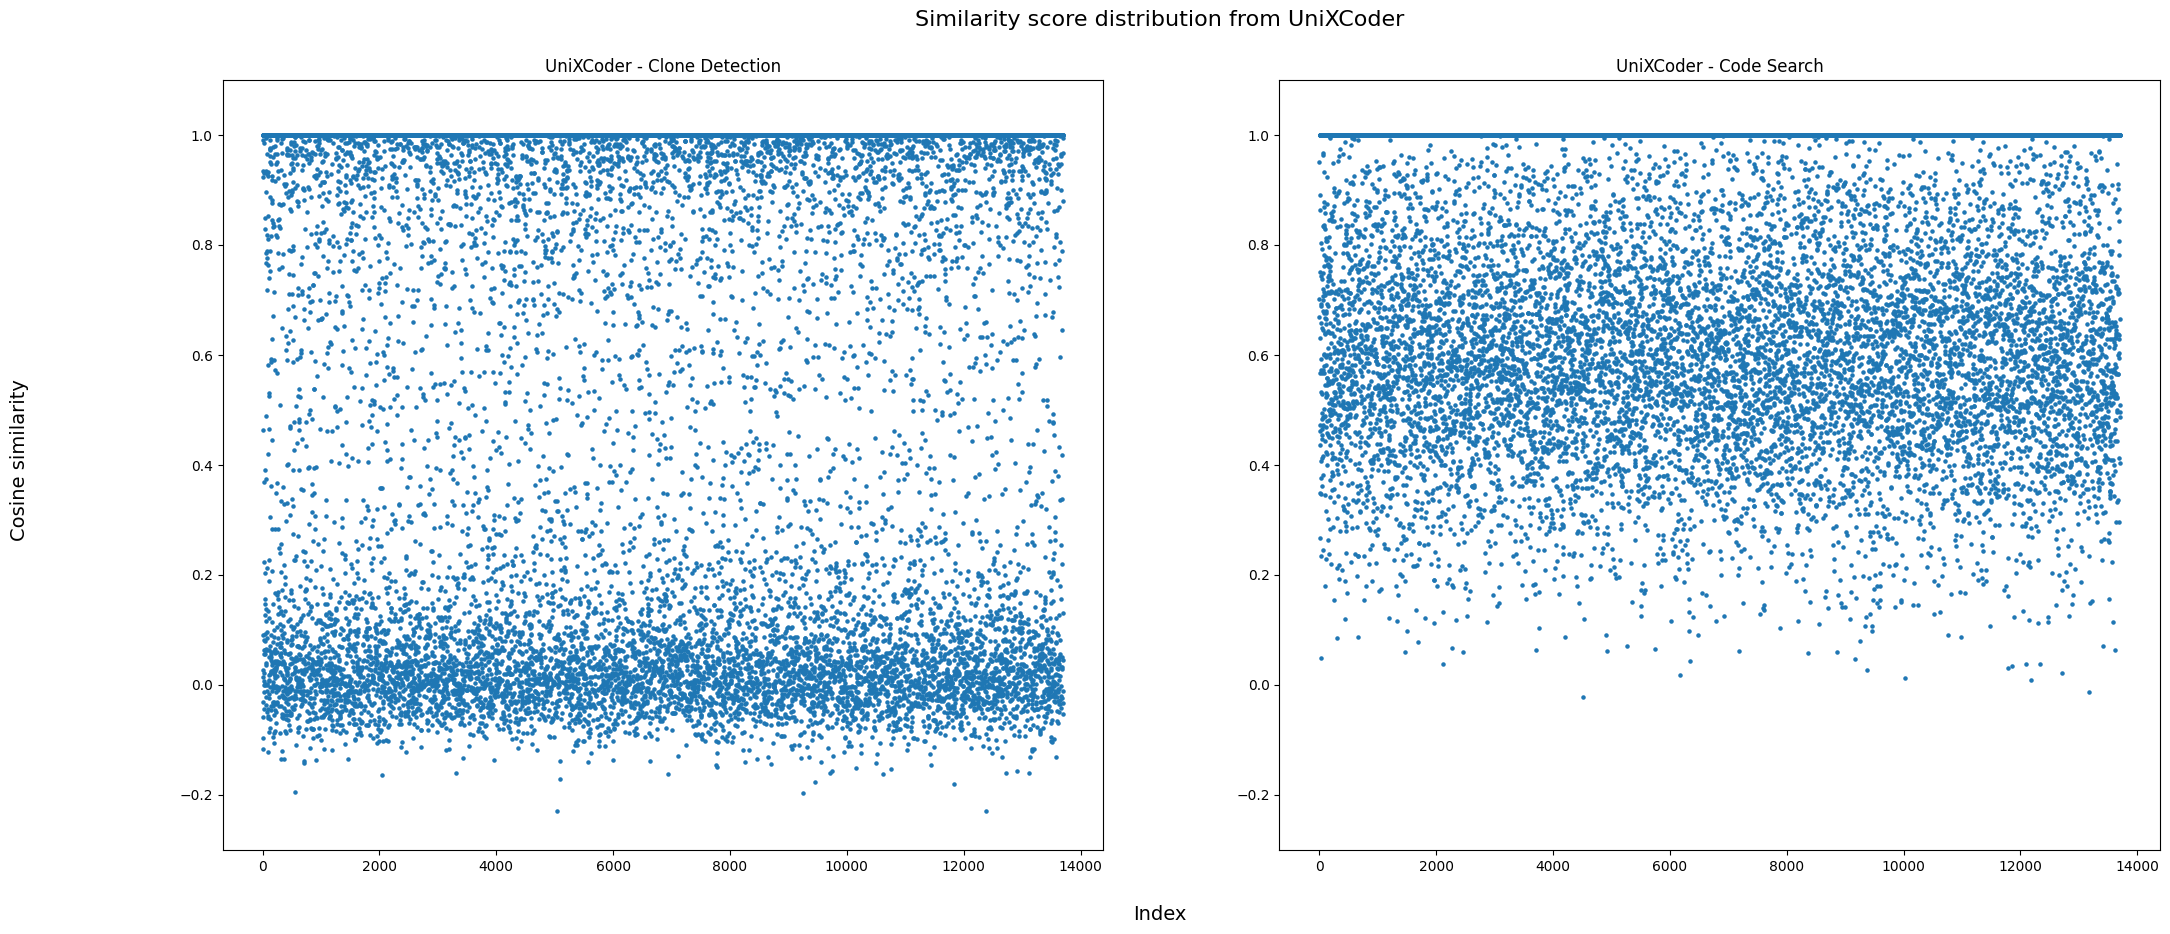

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.set_title('UniXCoder - Clone Detection')
ax1.scatter(clone_detection_scores.index, clone_detection_scores, s=5)

ax2.set_title('UniXCoder - Code Search')
ax2.scatter(code_search_scores.index, code_search_scores, s=5)

# Set the same y-axis limits for both subplots
ymin, ymax = min(clone_detection_scores.min(), code_search_scores.min()), max(clone_detection_scores.max(), code_search_scores.max())
ax1.set_ylim(-0.3, 1.1)
ax2.set_ylim(-0.3, 1.1)

# Add x and y axis labels of the main figure
fig.text(0.5, 0.04, 'Index', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Cosine similarity', va='center', rotation='vertical', fontsize=14)

# Add a main title for the whole figure
fig.suptitle('Similarity score distribution from UniXCoder', fontsize=16, y=0.95)

# plt.savefig('cossim_distribution.eps')
plt.show()